In [12]:
from tfdiff.params import all_params
from tfdiff.diffusion import GaussianDiffusion, SignalDiffusion
from scipy.io import loadmat
import os
import numpy as np

params = all_params[4]
diffusion = SignalDiffusion(params)

data_path = '/mnt/data/WQ/LoRAT/log/coordCSI/exp_test_10_10/internediate/data_350000.npz'
data = np.load(data_path, allow_pickle=True)
original, degrade, pred, cond, t = data['data'], data['degrade_data'], data['predicted'], data['cond'], data['t']
print(original.shape, degrade.shape, pred.shape, cond.shape, t)

(8, 201, 216, 2) (8, 201, 216, 2) (8, 201, 216, 2) (8, 3, 2) [ 41  79 120  27  33  47 101  20]


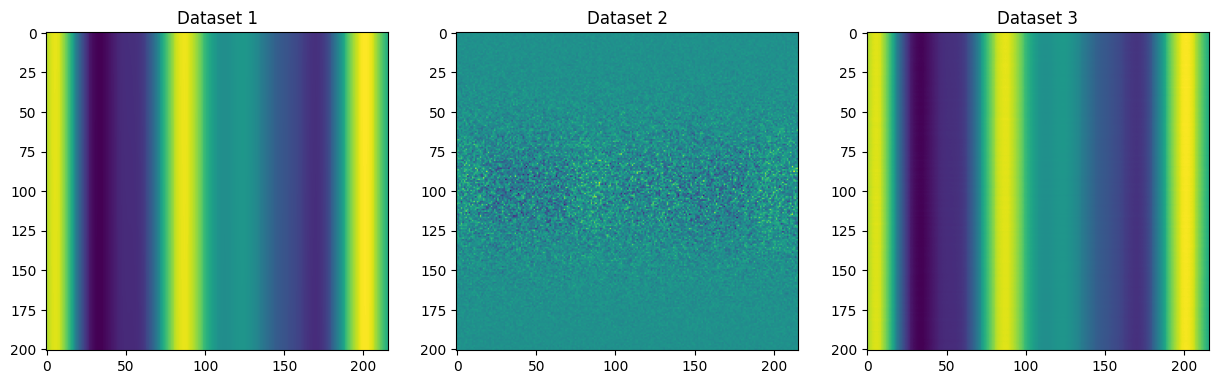

In [10]:
import matplotlib.pyplot as plt

def plot(data, smp_ind=0, ir=0):
    if data.dtype == 'complex64':
        data = np.stack([np.real(data), np.imag(data)], axis=-1)
    plt.figure()
    plt.imshow(data[smp_ind, :, :, ir])

def plot_triplet(*datasets, smp_ind=0, ir=0):
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(15, 5))
    
    for i, data in enumerate(datasets):
        if data.dtype == 'complex64':
            data = np.stack([np.real(data), np.imag(data)], axis=-1)
        axes[i].imshow(data[smp_ind, :, :, ir])
        axes[i].set_title(f'Dataset {i+1}')
        
    plt.show()

# Example usage
plot_triplet(original, degrade, pred, smp_ind=0)

In [13]:
from tfdiff.coord2CSI_model import tfdiff_coord2CSI
import torch

# model_dir = '/home/zuser/project/WQ/RF_Diffusion/RF-Diffusion/model/coordCSI/exp_test_10_10/weights-348300.pt'
# model = tfdiff_coord2CSI(params)
# model.load_state_dict(torch.load(model_dir)['model'])

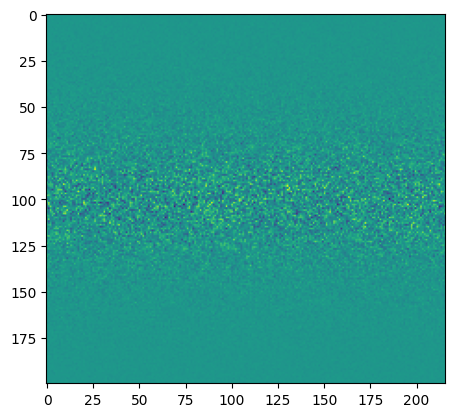

In [28]:
degrade_custom = diffusion.degrade_fn(torch.tensor(original[:, 1:, :, :], dtype=torch.float32), 100*torch.ones(8, dtype=torch.int64), 4)
plot(degrade_custom.detach().numpy())

/tmp/ipykernel_1232271/2282439768.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  restore = model(torch.tensor(degrade_custom, dtype=torch.float32), 100*torch.ones(8, dtype=torch.int64), torch.tensor(cond, dtype=torch.float32))


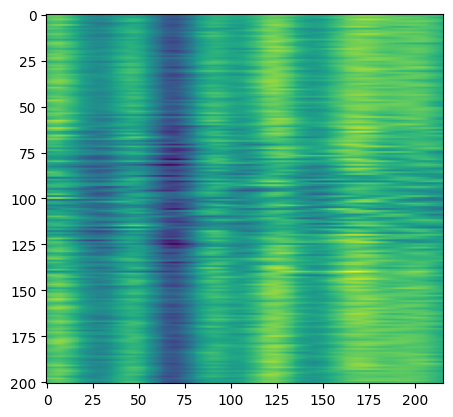

In [49]:
restore = model(torch.tensor(degrade_custom, dtype=torch.float32), 100*torch.ones(8, dtype=torch.int64), torch.tensor(cond, dtype=torch.float32))
plot(restore.detach().numpy(), smp_ind=6)

In [4]:
import torch

def cal_snr(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    # kl_divergence = np.mean(np.log(std_dev) + (data - mean)**2 / (2 * std_dev**2) - 0.5)
    kl_divergence = (mean/std_dev)**2
    return kl_divergence
degrade_list = []
x_0 = torch.from_numpy(original).to(device='cpu', dtype=torch.float32)
for t in range(200):
    degrade_list.append(diffusion.degrade_fn(x_0, t, 4))


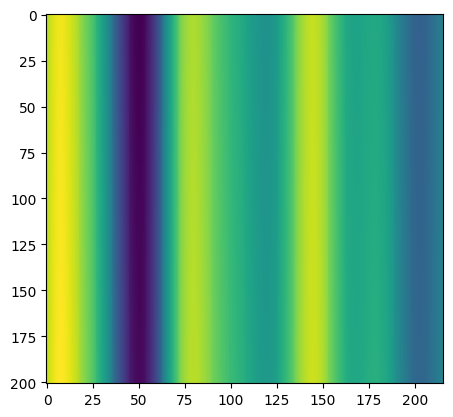

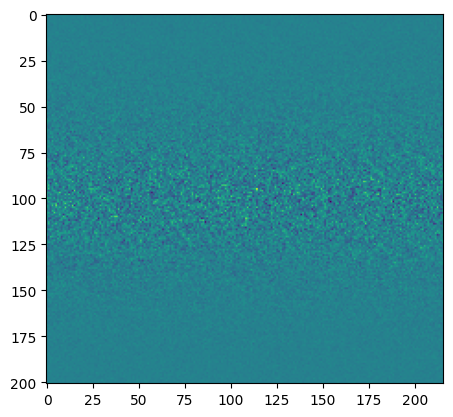

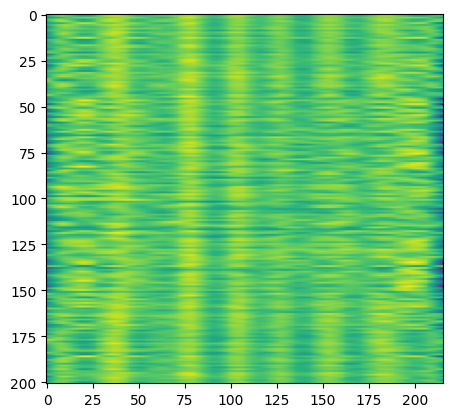

In [38]:
import matplotlib.pyplot as plt

    
data = '/home/zuser/project/WQ/RF_Diffusion/RF-Diffusion/output/coordCSI/exp_test_10_10/batch-0-0.mat'
data = loadmat(data)
pred, original, cond = data['pred'], data['original'], data['cond']
original = np.stack([np.real(original), np.imag(original)], axis=-1)
cond = np.stack([np.real(cond), np.imag(cond)], axis=-1)
original = torch.from_numpy(original).to(device='cpu', dtype=torch.float32)
cond = torch.from_numpy(cond).to(device='cpu', dtype=torch.float32)
t = 199
degrade = diffusion.degrade_fn(original, t, 4)
plot(original)
plot(degrade)
restore = model(degrade, torch.tensor([t]).to(dtype=torch.int32, device='cpu'), cond)
plot(restore.detach().numpy())